This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import scipy.linalg as linalg
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

from CovNet import Network_Full, MatrixDataset, symmetric_log, symmetric_exp, matrix_loss, try_gpu

In [2]:
train_log = False
train_inverse = False
#N = 52500
N = 5000
training_dir = "/home/jadamo/CovA-NN-Emulator/Data/Training-Set/"
save_dir = "/home/jadamo/CovA-NN-Emulator/Plots/"
BOSS_dir = "/home/jadamo/CovA-NN-Emulator/Data/BOSS-DR12/"
CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"

In [3]:
t1 = time.time()
data = MatrixDataset(training_dir, N, 0, train_log, train_inverse)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 11.11 s


In [4]:
non_positive_diag = []
non_symmetric = []
non_definete = []
t1 = time.time()
cholesky_fail = 0

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in range(N):
    C = data[i][1].cpu().detach().numpy()
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if C[i,i] <= 0:
            non_positive_diag.append(i)
            break
    
    # test assymetry
    C_sym = 0.5*(C + C.T)
    C_asym = 0.5*(C - C.T)
    symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen > 0.) == False:
        non_definete.append(i)
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
    except LinAlgError:
        cholesky_fail+=1
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag), "Matrices have non-positive diagonals")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices don't have all positive eigenvalues")
print(cholesky_fail, "Matricec fail to do cholesky decomposition")

Done! took 1 minutes 14.74 seconds
0 Matrices have non-positive diagonals
1031 (20.62%) Matrices are assymetric
min / max symmetric val: [1.006e-14, 2.949e-13] (avg = 5.269e-14
0 Matrices don't have all positive eigenvalues
0 Matricec fail to do cholesky decomposition


In [5]:
# now test the inverse matrix

non_positive_diag_inv = []
non_symmetric_inv = []
non_definete_inv = []
min_asym = 10000; max_asym = 0; avg_asym = 0.
t1 = time.time()
for i in range(N):
    C = data[i][1].detach().numpy()
    P = np.linalg.inv(C)
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if P[i,i] <= 0:
            non_positive_diag_inv.append(i)
            break
    
    # test assymetry
    P_sym = 0.5*(P + P.T)
    P_asym = 0.5*(P - P.T)
    symmetric_val = np.linalg.norm(P_asym, 2) / np.linalg.norm(P_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric_inv.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(P)
    if np.all(eigen > 0.) == False:
        non_definete_inv.append(i)
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag_inv), "Matrices have non-positive diagonals")
print(len(non_symmetric_inv), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric_inv)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete_inv), "Matrices don't have all positive eigenvalues")

KeyboardInterrupt: 

0


<Figure size 432x288 with 0 Axes>

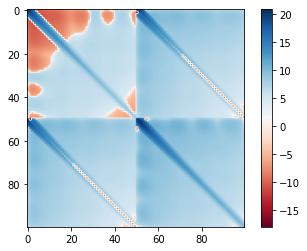

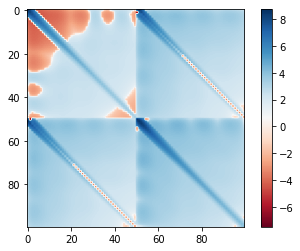

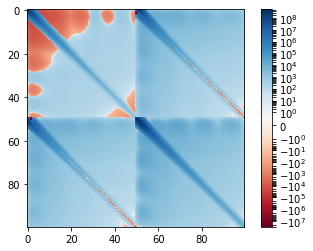

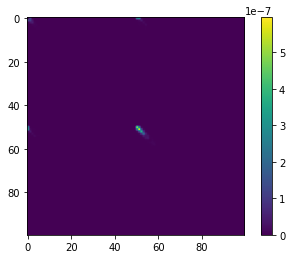

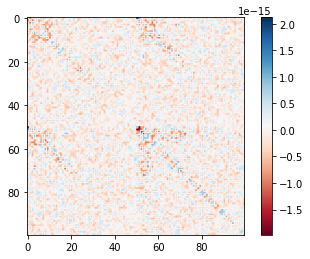

In [31]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = data[idx][1]
C_log = symmetric_log(C); C_1 = symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
idx_bad = np.where(abs((C - C_1) / C) > 1e-14)
print(len(idx_bad[0]))
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(C_sinh, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow((C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [8]:
from CovNet import symmetric_log, symmetric_exp, try_gpu
x = torch.linspace(-100, 100, 25, device=try_gpu())
x_log = symmetric_log(x)
x_1 = symmetric_exp(x_log)
print(x)
print(x_log)
print(x_1)
print(x_1 - x)

tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00,  3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5.0000e+01,  5.8333e+01,
         6.6667e+01,  7.5000e+01,  8.3333e+01,  9.1667e+01,  1.0000e+02],
       device='cuda:0')
tensor([-2.0043e+00, -1.9669e+00, -1.9260e+00, -1.8808e+00, -1.8304e+00,
        -1.7733e+00, -1.7076e+00, -1.6301e+00, -1.5357e+00, -1.4150e+00,
        -1.2472e+00, -9.7004e-01,  1.6567e-06,  9.7004e-01,  1.2472e+00,
         1.4150e+00,  1.5357e+00,  1.6301e+00,  1.7076e+00,  1.7733e+00,
         1.8304e+00,  1.8808e+00,  1.9260e+00,  1.9669e+00,  2.0043e+00],
       device='cuda:0')
tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00,  3.8147e-06,  8.3333e+00,  1.6667e+01,
 

In [28]:
# Convert data in .txt format to data in .npz format
# training_dir = "/home/joeadamo/Research/Data/Training-Set/"
# new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
# for idx in range(52500):
    
#     file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
#     f = open(file)
#     header = f.readline()
#     header = f.readline()
#     f.close()
#     header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
#     params = torch.cat([header[0:4], header[5:]]).detach().numpy()
#     # load in matrix
#     C = np.loadtxt(file, skiprows=2)
#     np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
#     test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
#     params_l = test["params"]; C_l = test["C"]
#     assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
# print("Done!")

Done!


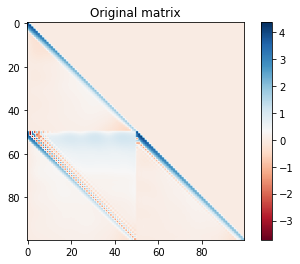

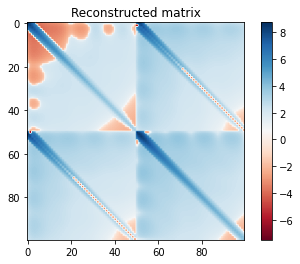

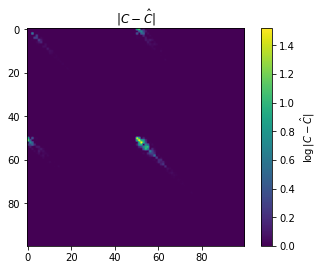

In [6]:
# try taking C as the "data" instead of the covariance matrix 
idx = np.random.randint(0, N)
C = data[idx][1]
L = torch.linalg.cholesky(C)
C_1 = torch.matmul(L, torch.t(L))

plt.figure()
plt.title("Original matrix")
plt.imshow(symmetric_log(L).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title("Reconstructed matrix")
plt.imshow(symmetric_log(C_1).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title(r"$|C - \hat{C}|$")
plt.imshow(symmetric_log(abs(C - C_1)).cpu())
cbar = plt.colorbar()
cbar.set_label(r"$\log{|C - \hat{C}|}$")

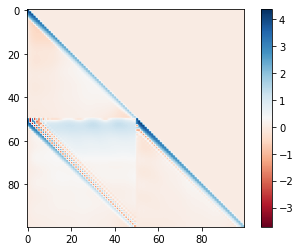

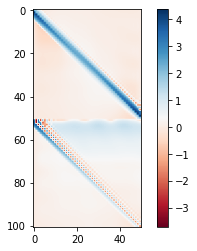

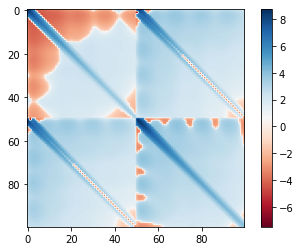

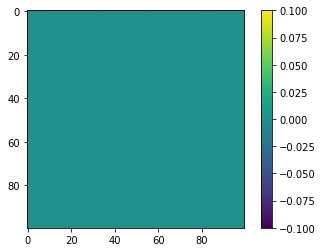

In [13]:
train_cholesky = True
idx = np.random.randint(0, N)
C = data[idx][1].view(1,100,100)
#C = symmetric_log(C)

if train_cholesky:
    C = torch.linalg.cholesky(C)
B = C.shape[0]
L1 = torch.tril(C)[:,:,:50]; L2 = torch.tril(C)[:,:,50:]
L1 = torch.cat((torch.zeros((B,1, 50), device=try_gpu()), L1), 1)
L2 = torch.cat((torch.flip(L2, [1,2]), torch.zeros((B,1, 50), device=try_gpu())),1)
C_half = L1 + L2

C_full = torch.zeros((B, 100,100), device=try_gpu())
C_full[:,:,:50] = C_full[:,:,:50] + C_half[:,1:,:]
C_full[:,:,50:] = C_full[:,:,50:] + torch.flip(C_half[:,:-1,:], [1,2])
L = torch.tril(C_full); U = torch.transpose(torch.tril(C_full, diagonal=-1),1,2)
if train_cholesky: # <- undo the cholesky decomposition
    C_full = torch.matmul(L, torch.transpose(L, 1, 2))
else:
    C_full = L + U

L = L.view(100,100); C = C.view(100,100); C_half = C_half.view(101,50); C_full = C_full.view(100,100)
plt.imshow((symmetric_log(C).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_half).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_full).cpu()), cmap="RdBu")
cbar = plt.colorbar()
# try training the quadrants independently

plt.figure()
plt.imshow(abs(torch.matmul(C, torch.t(C)) - C_full).cpu())
cbar = plt.colorbar()

idx =  2101
tensor([8.7467, 8.1228, 7.7816, 7.4918, 7.2226, 6.9704, 6.7221, 6.5018, 6.3059,
        6.1273, 5.9760, 5.8507, 5.7314, 5.6151, 5.5007, 5.3865, 5.2701, 5.1568,
        5.0455, 4.9442, 4.8521, 4.7720, 4.7006, 4.6333, 4.5716, 4.5098, 4.4475,
        4.3860, 4.3231, 4.2609, 4.2008, 4.1447, 4.0925, 4.0421, 3.9978, 3.9540,
        3.9127, 3.8702, 3.8316, 3.7910, 3.7515, 3.7118, 3.6735, 3.6347, 3.5995,
        3.5624, 3.5282, 3.4940, 3.4593, 3.4251, 8.6737, 8.5560, 8.3825, 8.1527,
        7.9056, 7.6650, 7.4257, 7.2098, 7.0150, 6.8368, 6.6842, 6.5546, 6.4364,
        6.3208, 6.2042, 6.0874, 5.9712, 5.8569, 5.7442, 5.6418, 5.5505, 5.4663,
        5.3952, 5.3229, 5.2604, 5.1963, 5.1319, 5.0688, 5.0049, 4.9416, 4.8808,
        4.8229, 4.7692, 4.7180, 4.6710, 4.6261, 4.5842, 4.5393, 4.4983, 4.4580,
        4.4169, 4.3788, 4.3394, 4.3017, 4.2645, 4.2296, 4.1944, 4.1631, 4.1306,
        4.0993], device='cuda:0')


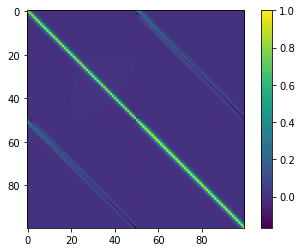

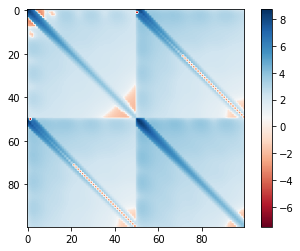

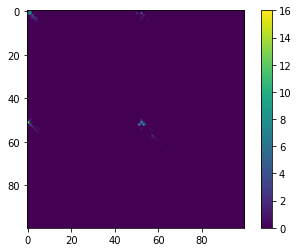

In [35]:
# test code to convert to / from correlation matrix
idx = np.random.randint(0, N)
print("idx = ", idx)
C = data[idx][1]
D = torch.sqrt(torch.diag(C)); D = torch.diag(D)
Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
print(symmetric_log(torch.diag(C)))

C_1 = torch.matmul(D, torch.matmul(Corr, D))

plt.figure()
plt.imshow(Corr.cpu())
cbar = plt.colorbar()

plt.figure()
plt.imshow(symmetric_log(C_1).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C).cpu( n))
cbar = plt.colorbar()